In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
tf.enable_v2_behavior()
import numpy as np
import lanczos_algorithm

(60, 2)
(60,)


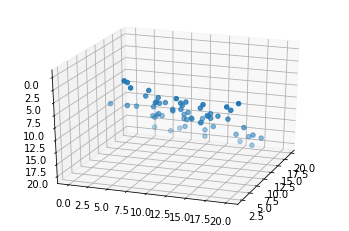

In [3]:
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

num_samples = 60
num_features = 2

x, y, coef = datasets.make_regression(n_samples=num_samples,      #number of samples
                                      n_features=num_features,    #number of features
                                      n_informative=num_features, #number of useful features 
                                      noise=10,                   #bias and standard deviation of the guassian noise
                                      coef=True,                  #true coefficient used to generated the data
                                      random_state=0)             #set for same data points for each run

X = np.interp(x, (x.min(), x.max()), (0, 20))

y = np.interp(y, (y.min(), y.max()), (0, 20))

print(x.shape)
print(y.shape)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(-155, -20)


ax.scatter(X[:,0],X[:,1],y)

plt.show()

# plt.ion() #interactive plot on
# plt.plot(x,y,'.',label='training data')
# plt.xlabel('x');plt.ylabel('y')


(60, 2)
(60,)
0.0 0.0
(2500,) (2500,)
(2500,)
(60,) (60,) (60,)


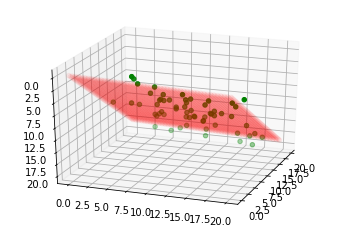

In [4]:
class GradientDescentLinearRegression:
    def __init__(self, learning_rate=0.0001, iterations=1000):
        
        self.__lr, self.itr = learning_rate, iterations
    
    def fit(self, X, y):
        n,d = X.shape[0],X.shape[1]
        self.b = 0
        self.w = np.zeros(d)
        self.w.fill(2)

        for _ in range(self.itr):
            
#             print(X.shape,self.w.shape)
            h = X@self.w + self.b
            dw =  X.T@ (h-y)  / n
            db = np.sum(h-y)  / n
            self.w = self.w - self.__lr*dw
            self.b = self.b - self.__lr*db
        
    def predict(self, X):
        return X@self.w + self.b
    

clf = GradientDescentLinearRegression()
print(X.shape)
print(y.shape)
clf.fit(X, y)

import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

minX = min(np.min(X[:,0]), np.min(X[:,1]))
maxX = min(np.max(X[:,0]), np.max(X[:,1]))


tmp = np.linspace(minX,maxX,50)
x1, x2 = np.meshgrid(tmp,tmp)
x1=x1.flatten()
x2=x2.flatten()
print(x1[0],x2[0])
print(x1.shape,x2.shape)
y_pred = []
for i in range(x1.shape[0]):
    y_pred.append(clf.predict([x1[i],x2[i]]))
y_pred = np.array(y_pred)
print(y_pred.shape)
print(X[:,0].shape,X[:,1].shape,y.shape)

ax.scatter(X[:,0],X[:,1],y,color='g')
ax.scatter(x1,x2, y_pred, alpha = 0.05,color='r')
ax.view_init(-155, -20)
plt.show()


In [5]:
H = X.T@X
print(H)

w,v = np.linalg.eig(H)
print(v*w@v.T-H)
print(w)
H_til=H/w[0]


[[8867.64632078 7351.54884359]
 [7351.54884359 8271.24731333]]
[[0.00000000e+00 0.00000000e+00]
 [9.09494702e-13 0.00000000e+00]]
[15927.04108039  1211.85255373]


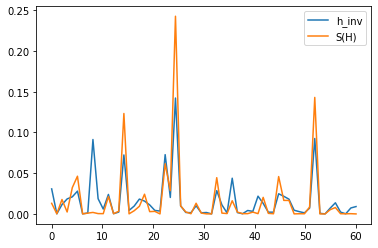

In [6]:
influence_x_H_inv = []
influence_x_SH = []

#low pass filter
w_til, v_til= np.linalg.eig(H_til)
w_til[0]=0
w_til[1]=1
S_H = v_til*w_til@v_til.T


for i in range(num_samples):
    x1,x2 = X[i][0], X[i][1]
    xi = np.array([x1,x2])
    h = clf.predict(xi)
#     print(h)
    dli = -(y[i]-h)*xi
    influence_x_H_inv.append(dli@np.linalg.inv(H)@dli)
    influence_x_SH.append(dli@S_H@dli)
    
# print(influence_x_H_inv/np.sum(influence_x_H_inv))
# print(influence_x_SH/np.sum(influence_x_SH))
x_axis = np.linspace(0,num_samples,num_samples)

p_H_inv = influence_x_H_inv/np.sum(influence_x_H_inv)
p_S_H = influence_x_SH/np.sum(influence_x_SH)
plt.plot(x_axis, p_H_inv, label="h_inv")
plt.plot(x_axis, p_S_H, label="S(H)")
plt.legend()
plt.show()



In [7]:
ind_Hinv = np.argsort(p_H_inv)[::-1]
ind_S_H = np.argsort(p_S_H)[::-1]

subsamp_per = 0.8
subsamp_num = int(num_samples*subsamp_per)
ind_Hinv_sub =  ind_Hinv[:subsamp_num]
ind_S_H_sub =  ind_S_H[:subsamp_num]
print(len(np.intersect1d(ind_Hinv_sub,ind_S_H_sub))/len(np.union1d(ind_Hinv_sub,ind_S_H_sub)))

0.8113207547169812


In [ ]:
def Chebyshev_step(deg, eps, damp):
    alpha1 = eps
    alpha2 = 1
    thetJ = math.pi/(deg+2)
    thetL = math.pi/(deg+1)
    a1 = 1/(deg+2)
    a2 = math.sin(thetJ)
    beta1 = math.acos(alpha1)
    beta2 = math.acos(alpha2)
    mu = np.zeros(deg+1)
    for k in range(deg+1):
        if damp == 0:
            jac = 1
        elif damp == 1:
            jac = a1*math.sin((k+1)*thetJ)/a2 + \
                (1-(k+1)*a1)*math.cos(k*thetJ)
        elif damp == 2:
            jac = 1
            if (k > 0):
                jac = math.sin(k*thetL)/(k*thetL)

        if k == 0:
            mu[k] = -jac*(beta2-beta1)/math.pi
        else:
            mu[k] = -2*jac*(
                math.sin(k*beta2)-math.sin(k*beta1))/(math.pi*k)

    return mu


In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
H = tf.matmul(V, tf.matmul(T, V, transpose_b=True))
plt.title("Hessian as estimated by Lanczos")
sns.heatmap(H)
plt.subplot(1,2,2)
plt.title("$2X^TX$")
sns.heatmap(2 * tf.matmul(X, X, transpose_a=True))
plt.show()

In [ ]:
import jax.density as density_lib

def plot(grids, density, label=None):
  plt.semilogy(grids, density, label=label)
  plt.ylim(1e-10, 1e2)
  plt.ylabel("Density")
  plt.xlabel("Eigenvalue")
  plt.legend()

density, grids = density_lib.tridiag_to_density(
    [T.numpy()], grid_len=10000, sigma_squared=1e-3)

plot(grids, density)